In [113]:
#Mining Massive Data Project
#Team Members: Subba Rao Illa, Sundaresh Narayanan, Shivam Panwar, Chirayu Sharma
#Building a Recommender System Based on Emotion


import itertools
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.metrics import plot_confusion_matrix
pd.set_option("display.max_rows", None, "display.max_columns", None)



In [68]:
#Reading all the used Datasets
completeDataSet = pd.read_csv('sentiment140.csv',header=None, encoding='latin-1')
IMDBdf = pd.read_csv("IMDb movies.csv")
spotifyDF=pd.read_csv("Spotify2000.csv")

In [84]:
#Describing Sizes of all 3 Datasets we used
number_of_tweets=0
number_of_movies=0
number_of_songs=0

index = completeDataSet.index
number_of_tweets = len(index)
print("Total Number of tweet records in Dataset: "+str(number_of_tweets))

index1=IMDBdf.index
number_of_movies = len(index1)
print("Total Number of movie records in Dataset: "+str(number_of_movies))


index2=spotifyDF.index
number_of_songs = len(index2)
print("Total Number of song records in Dataset: "+str(number_of_songs))



Total Number of tweet records in Dataset: 1600498
Total Number of movie records in Dataset: 85854
Total Number of song records in Dataset: 1994


In [85]:
#Preprocessing the Tweets Data
tweets = completeDataSet[[0,5]]
tweets=tweets.rename(columns={0: "Label", 5: "tweet"})
tweets = tweets[tweets.Label != 2]
tweets['tweet'] = tweets['tweet'].apply(lambda tweet: tweet.lower())
tweets['tweet'] = tweets['tweet'].apply((lambda tweet: re.sub('[^a-zA-z\s]','',tweet)))
print("Here are Number of Happy and Sad Tweets, Label 4 represents Happy & 0 represents Sad")
tweets.Label.value_counts()

Here are Number of Happy and Sad Tweets, Label 4 represents Happy & 0 represents Sad


4    800182
0    800177
Name: Label, dtype: int64

In [86]:
#Tokkenizing the Tweets and converting them to Padded Sequences to train the data in LSTM
tokenizer = Tokenizer(num_words=1000, split=' ')
tokenizer.fit_on_texts(tweets['tweet'].values)
X_padded_seq = tokenizer.texts_to_sequences(tweets['tweet'].values)
X_padded_seq = pad_sequences(X_padded_seq)
Y_dummies = pd.get_dummies(tweets['Label']).values



#Preparing Training and Testing Split for two models


X_train, X_test, Y_train, Y_test = train_test_split(X_padded_seq,Y_dummies, test_size = 0.2, random_state = 42)
X1_train=X_train.copy()
X1_test=X_test.copy()
Y1_train = Y_train.copy()
Y1_test = Y_test.copy() 
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)

(1280287, 40) (1280287, 2)
(320072, 40) (320072, 2)
(1280287, 40) (1280287, 2)
(320072, 40) (320072, 2)


In [15]:
#Creating 2 LSTM Models
model = Sequential()
model.add(Embedding(1000, 128,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())



print("-----------------------------------------------------------------------------------------------")



model_2 = Sequential()
model_2.add(Embedding(1000, 128,input_length = X.shape[1]))
model_2.add(SpatialDropout1D(0.4))
model_2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_2.add(Dense(2,activation='softmax'))
model_2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           128000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 219,802
Trainable params: 219,802
Non-trainable params: 0
_________________________________________________________________
None
-----------------------------------------------------------------------------------------------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Pa

In [16]:
#These Callbacks are used when training, for early stopping and reducing learning rate 
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=1, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=2,restore_best_weights=True)]

In [17]:
#Training the Whole training Data at once 
batch_size = 1024
start_time=time.time()
classifier=model.fit(X_train, Y_train, epochs = 8, batch_size=batch_size,validation_split=0.1, verbose = 1,callbacks=callbacks)
end_time=time.time()
time_taken=end_time-start_time
print(time_taken)

/Users/subbuilla/opt/anaconda3/envs/kt/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1152258 samples, validate on 128029 samples
Epoch 1/8
1152258/1152258 [==============================] - 860s 747us/step - loss: 0.4892 - accuracy: 0.7621 - val_loss: 0.4639 - val_accuracy: 0.7776
Epoch 2/8
1152258/1152258 [==============================] - 875s 759us/step - loss: 0.4633 - accuracy: 0.7778 - val_loss: 0.4547 - val_accuracy: 0.7829
Epoch 3/8
1152258/1152258 [==============================] - 884s 768us/step - loss: 0.4567 - accuracy: 0.7819 - val_loss: 0.4504 - val_accuracy: 0.7848
Epoch 4/8
1152258/1152258 [==============================] - 889s 771us/step - loss: 0.4522 - accuracy: 0.7850 - val_loss: 0.4473 - val_accuracy: 0.7872
Epoch 5/8
1152258/1152258 [==============================] - 889s 771us/step - loss: 0.4488 - accuracy: 0.7866 - val_loss: 0.4437 - val_accuracy: 0.7893
Epoch 6/8
1152258/1152258 [==============================] - 894s 776us/step - loss: 0.4457 - accuracy: 0.7887 - val_loss: 0.4428 - val_accuracy: 0.7901
Epoch 7/8
1152258/1152258 [==

In [19]:
print('Time take to train whole data at once: '+str(time_taken))

Time take to train whole data at once: 7070.282289981842


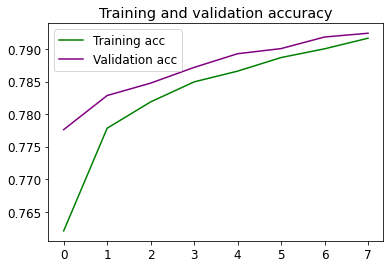

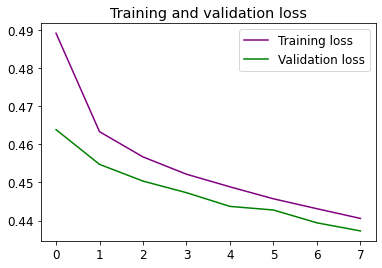

In [88]:
#Plotting Training,Validation Accuracy and Training,Validation Loss of the above trained model
epochs = range(len(classifier.history['accuracy']))
 
plt.plot(epochs, classifier.history['accuracy'], 'g', label='Training acc')
plt.plot(epochs, classifier.history['val_accuracy'], 'purple', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, classifier.history['loss'], 'purple', label='Training loss')
plt.plot(epochs, classifier.history['val_loss'], 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.rcParams.update({'font.size': 11})
plt.show()

In [18]:
#Training the Whole training Data in chunks 
flag=0
start=0
end=len(X1_train)//10
start_time_tl=time.time()
while True:
    trans_classifier=model_2.fit(X1_train[start:end], Y1_train[start:end], epochs = 8, batch_size=1024,validation_split=0.1, verbose = 1,callbacks=callbacks)
    flag+=1
    end=(len(X1_train)//10)+end
    start=start+(len(X1_train)//10)
    if flag==10:
        break
end_time_tl=time.time()
time_taken_tl=end_time_tl-start_time_tl
print(time_taken_tl)

/Users/subbuilla/opt/anaconda3/envs/kt/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 115225 samples, validate on 12803 samples
Epoch 1/8
115225/115225 [==============================] - 91s 789us/step - loss: 0.5632 - accuracy: 0.7041 - val_loss: 0.4907 - val_accuracy: 0.7625
Epoch 2/8
115225/115225 [==============================] - 89s 773us/step - loss: 0.4952 - accuracy: 0.7624 - val_loss: 0.4837 - val_accuracy: 0.7626
Epoch 3/8
115225/115225 [==============================] - 90s 779us/step - loss: 0.4854 - accuracy: 0.7671 - val_loss: 0.4808 - val_accuracy: 0.7653
Epoch 4/8
115225/115225 [==============================] - 89s 773us/step - loss: 0.4796 - accuracy: 0.7702 - val_loss: 0.4755 - val_accuracy: 0.7684
Epoch 5/8
115225/115225 [==============================] - 90s 781us/step - loss: 0.4732 - accuracy: 0.7730 - val_loss: 0.4726 - val_accuracy: 0.7687
Epoch 6/8
115225/115225 [==============================] - 89s 775us/step - loss: 0.4679 - accuracy: 0.7752 - val_loss: 0.4706 - val_accuracy: 0.7718
Epoch 7/8
115225/115225 [========================

In [89]:
print('Time take to train whole data in chunks repeatedly on the same model: '+str(time_taken_tl))

Time take to train whole data in chunks repeatedly on the same model: 3582.033767938614


In [33]:
X_te = X_test[-300000:]
Y_te = Y_test[-300000:]
X_test = X_test[:-300000]
Y_test = Y_test[:-300000]
X1_te = X1_test[-300000:]
Y1_te = Y1_test[-300000:]
X1_test = X1_test[:-300000]
Y1_test = Y1_test[:-300000]

In [90]:
#Classification Report of Initial Model
y_true=[]
y_pred=[]

for i in range(len(X_te)): 
    result = model.predict(X_te[i].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
    y_pred.append(np.argmax(result))
    y_true.append(np.argmax(Y_te[i]))
    
print("--------------------------------------------------------------")
print("Classification Report of Initial Model")
print(classification_report(y_true, y_pred))
print("--------------------------------------------------------------")


--------------------------------------------------------------
Classification Report of Initial Model
              precision    recall  f1-score   support

           0       0.79      0.80      0.79    149370
           1       0.80      0.79      0.79    150630

    accuracy                           0.79    300000
   macro avg       0.79      0.79      0.79    300000
weighted avg       0.79      0.79      0.79    300000

--------------------------------------------------------------


In [35]:
#Classification Report of Model ran with chunks
y_true_tl=[]
y_pred_tl=[]
for i in range(len(X1_te)):
    
    result1 = model_2.predict(X1_te[i].reshape(1,X1_test.shape[1]),batch_size=1,verbose = 2)[0]
    y_pred_tl.append(np.argmax(result1))
    y_true_tl.append(np.argmax(Y1_te[i]))
print("--------------------------------------------------------------")
print("Classification Report of Model ran with chunks")
print(classification_report(y_true_tl, y_pred_tl))
print("--------------------------------------------------------------")



--------------------------------------------------------------
Classification Report of Model ran with chunks
              precision    recall  f1-score   support

           0       0.78      0.78      0.78    149370
           1       0.78      0.78      0.78    150630

    accuracy                           0.78    300000
   macro avg       0.78      0.78      0.78    300000
weighted avg       0.78      0.78      0.78    300000

--------------------------------------------------------------


Confusion matrix, without normalization
Normalized confusion matrix


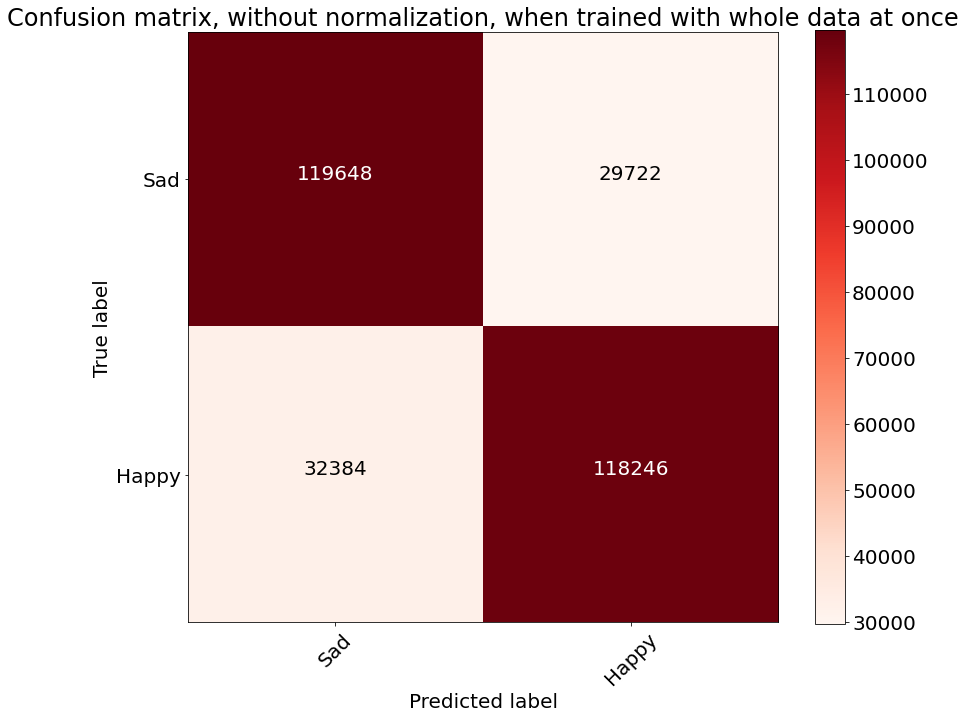

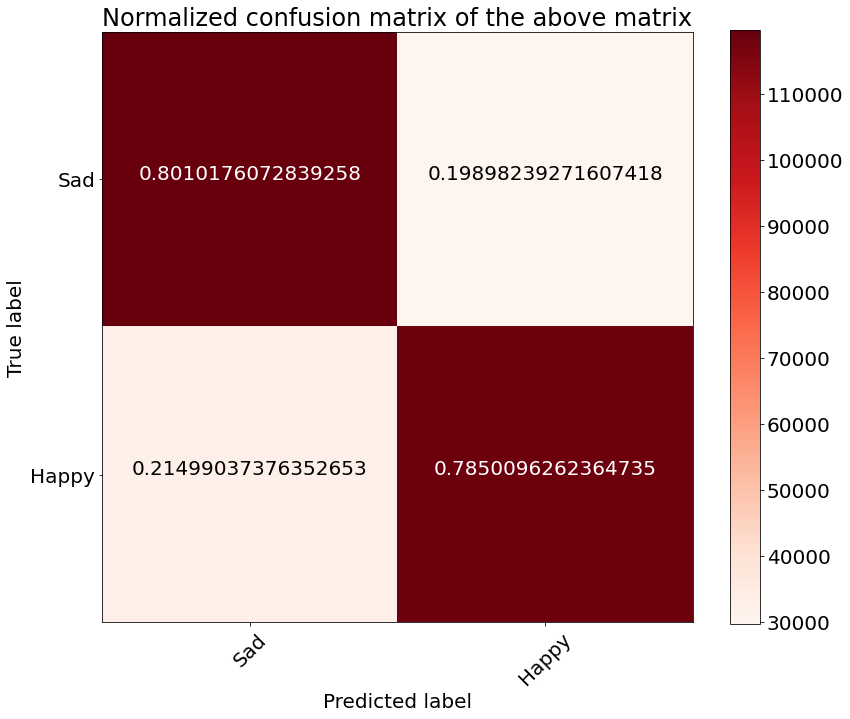

-------------------------------------------------------------------------------------------------


In [94]:
#Plotting Confusion Matrices
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)
 

########

labels = ["Sad", "Happy"]
c_mat = confusion_matrix(y_true, y_pred)
c_mat_tl = confusion_matrix(y_true_tl, y_pred_tl)
np.set_printoptions(precision=2)
# create confusion matrix

fi=plt.figure(figsize=(12,10))
plot_confusion_matrix(c_mat, classes=labels,
                      title='Confusion matrix, without normalization, when trained with whole data at once')

# Plot normalized confusion matrix
plt.figure(figsize=(12,10))
plot_confusion_matrix(c_mat, classes=labels, normalize=True,
                      title='Normalized confusion matrix of the above matrix')
plt.rcParams.update({'font.size': 20})
plt.show()
fi.savefig('test.jpg')

print("-------------------------------------------------------------------------------------------------")



Confusion matrix, without normalization
Normalized confusion matrix


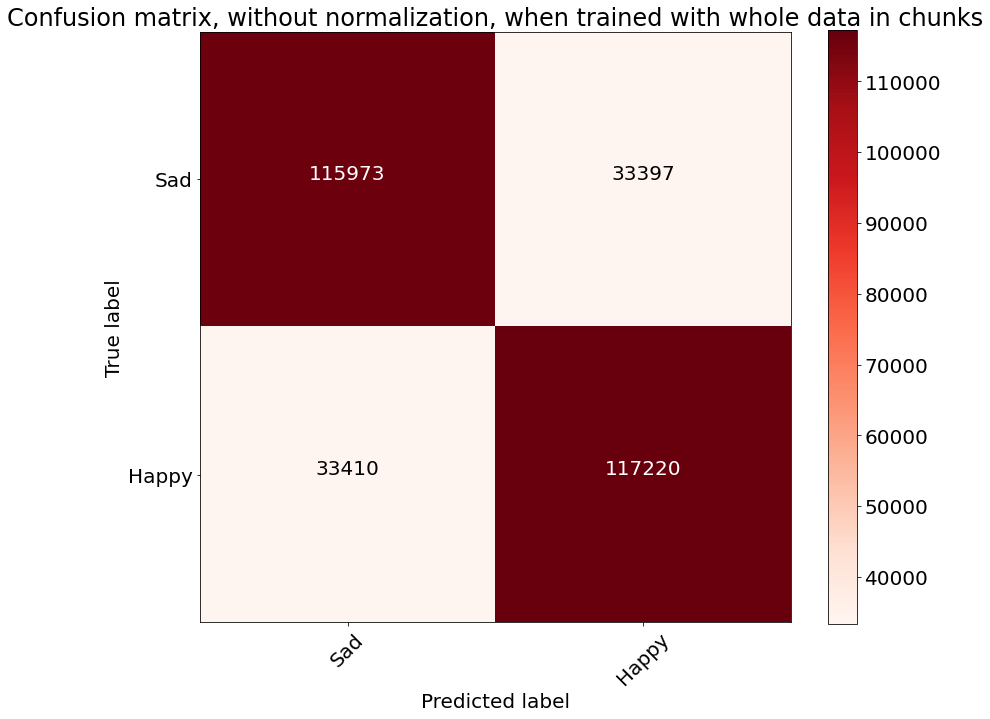

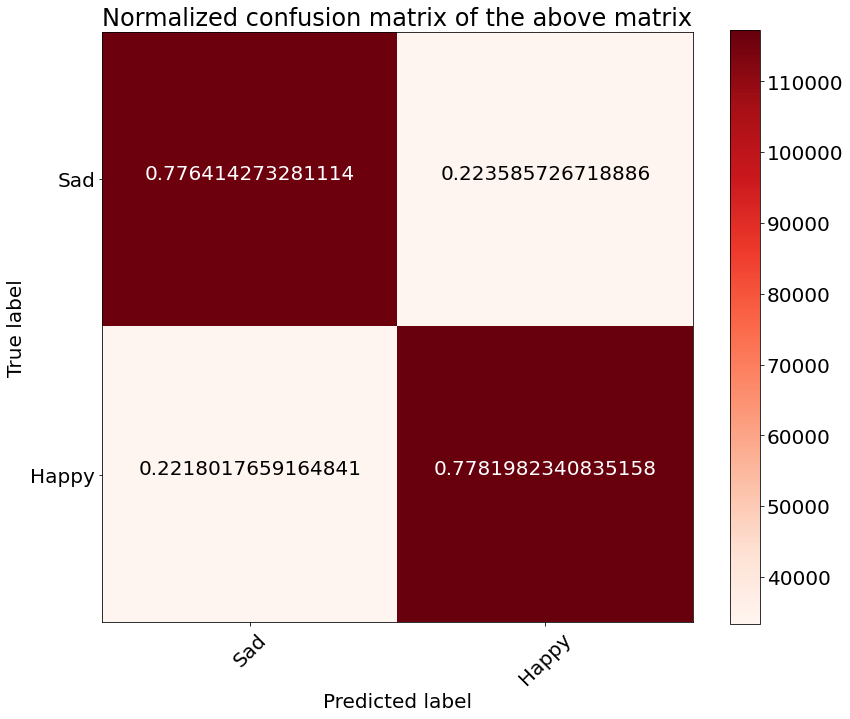

In [96]:
fi2=plt.figure(figsize=(12,10))
plot_confusion_matrix(c_mat_tl, classes=labels,
                      title='Confusion matrix, without normalization, when trained with whole data in chunks')

# Plot normalized confusion matrix
plt.figure(figsize=(12,10))
plot_confusion_matrix(c_mat_tl, classes=labels, normalize=True,
                      title='Normalized confusion matrix of the above matrix')
plt.rcParams.update({'font.size': 20})
plt.show()

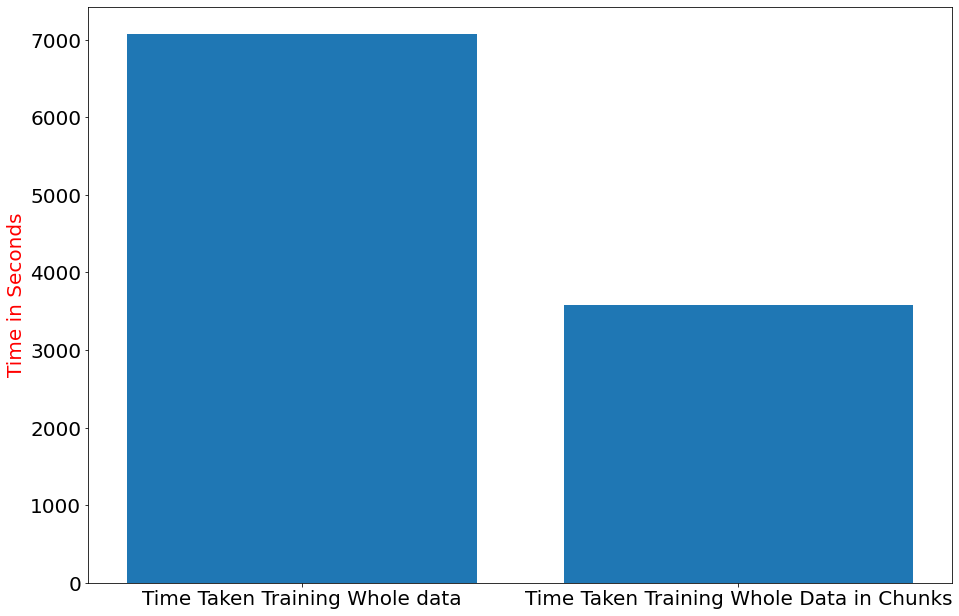

In [115]:
#Run Time Difference Between training with whole data at once and training whole data in chunks 
figu = plt.figure()
axe = figu.add_axes([1,1,2,2])
labels1 = ['Time Taken Training Whole data', 'Time Taken Training Whole Data in Chunks']
count1 = [time_taken,time_taken_tl]
axe.bar(labels1,count1)
axe.set_ylabel('Time in Seconds', color='red')
plt.rcParams.update({'font.size': 20})
plt.show()

In [97]:
#Sample Predictions of Both the Models
sample_texts = [["Thank God, My Pizza is here"],
                ["I hate you"],["I love you"],
                ["My food is taking forever to get delivered"]]
sample_texts_copy=sample_texts.copy()
predicted_sentiments=[]
for i in range(len(sample_texts)):  
    print("----------------------------------------")
    sample_texts_copy[i] = tokenizer.texts_to_sequences(sample_texts_copy[i])
    sample_texts_copy[i] = pad_sequences(sample_texts_copy[i], maxlen=40, dtype='int32', value=0)
    print("With Initial Model")
    sentiment = model.predict(sample_texts_copy[i],batch_size=1,verbose = 2)[0]
    print(sample_texts[i])

    if(np.argmax(sentiment) == 1):
        print("Happy")
        predicted_sentiments.append(1)
    else:
        print("Sad")
        predicted_sentiments.append(0)
    print("----------------------------------------")
    
    print("With Model_2")
    sentiment = model_2.predict(sample_texts_copy[i],batch_size=1,verbose = 2)[0]
    print(sample_texts[i])

    if(np.argmax(sentiment) == 1):
        print("Happy")
    else:
        print("Sad")
    print("----------------------------------------")

----------------------------------------
With Initial Model
['Thank God, My Pizza is here']
Happy
----------------------------------------
With Model_2
['Thank God, My Pizza is here']
Happy
----------------------------------------
----------------------------------------
With Initial Model
['I hate you']
Sad
----------------------------------------
With Model_2
['I hate you']
Sad
----------------------------------------
----------------------------------------
With Initial Model
['I love you']
Happy
----------------------------------------
With Model_2
['I love you']
Happy
----------------------------------------
----------------------------------------
With Initial Model
['My food is taking forever to get delivered']
Sad
----------------------------------------
With Model_2
['My food is taking forever to get delivered']
Sad
----------------------------------------


In [98]:
#Generating Movies of Country USA
IMDBdf = (pd.read_csv("IMDb movies.csv")
      [lambda x: x['country'] == 'USA'])

In [99]:
IMDBdf

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,11/13/12,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,"$45,000",NaN,NaN,NaN,25.0,3.0
5,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,1913,"Biography, Drama",60,USA,English,Sidney Olcott,...,"R. Henderson Bland, Percy Dyer, Gene Gauntier,...","An account of the life of Jesus Christ, based ...",5.7,484,NaN,NaN,NaN,NaN,13.0,5.0
17,tt0003167,Amore di madre,"Home, Sweet Home",1914,5/17/14,Drama,55,USA,English,D.W. Griffith,...,"Henry B. Walthall, Josephine Crowell, Lillian ...",John Howard Payne at his most miserable point ...,5.8,187,NaN,NaN,NaN,NaN,6.0,NaN
19,tt0003471,Traffic in Souls,Traffic in Souls,1913,11/24/13,"Crime, Drama",88,USA,English,George Loane Tucker,...,"Jane Gail, Ethel Grandin, William H. Turner, M...","A woman, with the aid of her police officer sw...",6.0,552,"$5,700",NaN,NaN,NaN,14.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85828,tt9887520,Season of Love,Season of Love,2019,11/30/19,"Comedy, Romance",105,USA,NaN,Christin Baker,...,"Dominique Provost-Chalkley, Jessica Clark, Emi...",A queer lady holiday romantic comedy that foll...,7.5,228,NaN,NaN,NaN,NaN,10.0,5.0
85829,tt9887580,Bulletproof 2,Bulletproof 2,2020,1/7/20,"Action, Comedy",97,USA,English,Don Michael Paul,...,"Faizon Love, Kirk Fox, Tony Todd, Cassie Clare...","Set 25 years after, Jack is now working as a S...",3.5,326,NaN,NaN,NaN,NaN,18.0,5.0
85836,tt9894470,VFW,VFW,2019,2/14/20,"Action, Crime, Horror",92,USA,English,Joe Begos,...,"Stephen Lang, William Sadler, Fred Williamson,...",A group of old war veterans put their lives on...,6.1,4178,NaN,NaN,"$23,101",72.0,83.0,94.0
85837,tt9896916,The Pilgrim's Progress,The Pilgrim's Progress,2019,4/18/19,"Animation, Adventure, Family",108,USA,English,Robert Fernandez,...,"David Thorpe, John Rhys-Davies, Kristyn Getty,...","An epic journey, faithfully adapted to modern-...",5.7,442,NaN,"$1,294,596","$3,173,282",NaN,28.0,3.0


In [100]:
#Filtering to get movies released after year 2000
movies_after_2000=IMDBdf.copy()

convert_dict = {'year': int, 
               } 
  
movies_after_2000 = movies_after_2000.astype(convert_dict) 

movies_after_2000=movies_after_2000[movies_after_2000['year'] >= 2000]

In [101]:
movies_after_2000

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
4334,tt0035423,Kate & Leopold,Kate & Leopold,2001,3/1/02,"Comedy, Fantasy, Romance",118,USA,"English, French",James Mangold,...,"Meg Ryan, Hugh Jackman, Liev Schreiber, Brecki...",An English Duke from 1876 is inadvertedly drag...,6.4,77852,"$48,000,000","$47,121,859","$76,019,048",44.0,341.0,115.0
21806,tt0088751,The Naked Monster,The Naked Monster,2005,4/22/05,"Comedy, Horror, Sci-Fi",100,USA,English,"Wayne Berwick, Ted Newsom",...,"Kenneth Tobey, Brinke Stevens, R.G. Wilson, Jo...","A brain-dead sheriff, a stolid secret agent an...",5.4,264,PYG 350000000,NaN,NaN,NaN,15.0,8.0
28888,tt0113026,The Fantasticks,The Fantasticks,2000,9/22/00,"Musical, Romance",86,USA,English,Michael Ritchie,...,"Joel Grey, Barnard Hughes, Jean Louisa Kelly, ...",A mysterious fair that comes to a small commun...,5.6,1097,"$10,000,000","$49,666","$49,666",48.0,70.0,24.0
28913,tt0113092,For the Cause,For the Cause,2000,11/16/00,"Action, Adventure, Drama",100,USA,English,"David Douglas, Tim Douglas",...,"Dean Cain, Thomas Ian Griffith, Justin Whalin,...",Earth is in a state of constant war and two co...,3.5,746,NaN,NaN,NaN,NaN,9.0,7.0
29307,tt0114447,The Silent Force,The Silent Force,2001,5/22/01,Action,90,USA,English,David H. May,...,"Loren Avedon, Brian Tochi, Karen Kim, George C...",An elite Federal force whose objective is to e...,4.3,126,NaN,NaN,NaN,NaN,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85828,tt9887520,Season of Love,Season of Love,2019,11/30/19,"Comedy, Romance",105,USA,NaN,Christin Baker,...,"Dominique Provost-Chalkley, Jessica Clark, Emi...",A queer lady holiday romantic comedy that foll...,7.5,228,NaN,NaN,NaN,NaN,10.0,5.0
85829,tt9887580,Bulletproof 2,Bulletproof 2,2020,1/7/20,"Action, Comedy",97,USA,English,Don Michael Paul,...,"Faizon Love, Kirk Fox, Tony Todd, Cassie Clare...","Set 25 years after, Jack is now working as a S...",3.5,326,NaN,NaN,NaN,NaN,18.0,5.0
85836,tt9894470,VFW,VFW,2019,2/14/20,"Action, Crime, Horror",92,USA,English,Joe Begos,...,"Stephen Lang, William Sadler, Fred Williamson,...",A group of old war veterans put their lives on...,6.1,4178,NaN,NaN,"$23,101",72.0,83.0,94.0
85837,tt9896916,The Pilgrim's Progress,The Pilgrim's Progress,2019,4/18/19,"Animation, Adventure, Family",108,USA,English,Robert Fernandez,...,"David Thorpe, John Rhys-Davies, Kristyn Getty,...","An epic journey, faithfully adapted to modern-...",5.7,442,NaN,"$1,294,596","$3,173,282",NaN,28.0,3.0


In [102]:
#Filtering Movies based on Respective Generes and sort them by popularity in descending order
action_comedy_scifi=movies_after_2000[movies_after_2000.genre.str.contains('Action, Comedy') | movies_after_2000.genre.str.contains('Sci-Fi') ]
romantic_drama_thriller=movies_after_2000[movies_after_2000.genre.str.contains('Romance') | movies_after_2000.genre.str.contains('Drama') | movies_after_2000.genre.str.contains('Thriller')]
romantic_drama_thriller = romantic_drama_thriller.sort_values(by = 'avg_vote', ascending = False)
action_comedy_scifi = action_comedy_scifi.sort_values(by = 'avg_vote', ascending = False)


In [103]:
action_comedy_scifi

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
73864,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,4/25/18,"Action, Adventure, Sci-Fi",149,USA,English,"Anthony Russo, Joe Russo",...,"Robert Downey Jr., Chris Hemsworth, Mark Ruffa...",The Avengers and their allies must be willing ...,8.4,796486,"$321,000,000","$678,815,482","$2,048,359,754",68.0,4273.0,611.0
42569,tt0338013,Se mi lasci ti cancello,Eternal Sunshine of the Spotless Mind,2004,10/22/04,"Drama, Romance, Sci-Fi",108,USA,English,Michel Gondry,...,"Jim Carrey, Kate Winslet, Gerry Robert Byrne, ...","When their relationship turns sour, a couple u...",8.3,889875,"$20,000,000","$34,400,301","$74,036,715",89.0,1825.0,297.0
75596,tt4730224,An Hour to Kill,An Hour to Kill,2018,6/12/18,"Action, Comedy, Horror",96,USA,English,Aaron K. Carter,...,"Mel Novak, Frankie Pozos, Aaron Guerrero, Aman...",Two assassins-for-hire have an hour to kill be...,8.2,2154,"$60,000",NaN,NaN,NaN,15.0,108.0
64031,tt2044863,Starship,Starship,2011,4/30/11,"Fantasy, Musical, Sci-Fi",172,USA,English,Matt Lang,...,"Joey Richter, Brant Cox, Nick Lang, Lauren Lop...","Bug wants to be a Starship Ranger, but there's...",8.1,626,NaN,NaN,NaN,NaN,1.0,NaN
70744,tt3315342,Logan - The Wolverine,Logan,2017,3/1/17,"Action, Drama, Sci-Fi",137,USA,"English, Spanish",James Mangold,...,"Hugh Jackman, Patrick Stewart, Dafne Keen, Boy...","In a future where mutants are nearly extinct, ...",8.1,627493,"$97,000,000","$226,277,068","$619,021,436",77.0,1574.0,644.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62663,tt1854506,Aliens vs. Avatars,Aliens vs. Avatars,2011,9/20/11,"Horror, Sci-Fi",80,USA,English,Lewis Schoenbrun,...,"Jason Lockhart, Kim Argetsinger, Cassie Fliege...",Six college friends find themselves caught up ...,1.5,1582,NaN,NaN,NaN,NaN,27.0,10.0
69918,tt3120314,Shark Exorcist,Shark Exorcist,2015,8/14/15,"Action, Comedy, Fantasy",71,USA,English,Donald Farmer,...,"Angela Kerecz, Bobby Kerecz, Channing Dodson, ...",A demonic nun unleashes holy hell when she sum...,1.3,1160,"$300,000",NaN,NaN,NaN,38.0,16.0
66901,tt2387413,Captain Battle: Legacy War,Captain Battle: Legacy War,2013,1/13/13,"Action, Sci-Fi, War",90,USA,"English, Spanish",David Palmieri,...,"Cuyle Carvin, Andrew J McGuinness, Marlene Mc'...",SAM BATTLE is injured during his tour of duty ...,1.2,415,NaN,NaN,NaN,NaN,8.0,4.0
77396,tt5311054,Browncoats: Independence War,Browncoats: Independence War,2015,12/30/15,"Action, Sci-Fi, War",98,USA,English,Francis Hamada,...,"Beth Bemis, Richard Martinsen, Will James John...","A group of soldiers, on the last day of a War,...",1.1,717,NaN,NaN,NaN,NaN,4.0,NaN


In [104]:
romantic_drama_thriller

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
58809,tt1508669,Hopeful Notes,Hopeful Notes,2010,12/15/10,Drama,94,USA,English,Valerio Zanoli,...,"Walter Nudo, Colin Ross, Ian Poland, Laural Me...",A young violinist with leukemia brings hope an...,9.7,669,"$1,500,000",NaN,NaN,NaN,2.0,2.0
52570,tt10218912,As I Am,As I Am,2019,12/6/19,"Drama, Fantasy, Romance",62,USA,English,Anthony Bawn,...,"Andre Myers, Jerimiyah Dunbar, Rodney Chester,...",A story of a young man running from the truth ...,9.3,1173,"$10,000",NaN,NaN,NaN,5.0,NaN
79258,tt5980638,The Transcendents,The Transcendents,2018,6/19/20,"Music, Mystery, Thriller",96,USA,English,Derek Ahonen,...,"Rob Franco, Savannah Welch, Kathy Valentine, W...","Roger, a Rasputin-like drifter, is in search o...",9.2,1450,"$90,000","$1,090","$1,090",NaN,3.0,4.0
79532,tt6074834,Delaware Shore,Delaware Shore,2018,12/21/18,Drama,98,USA,English,Raghav Peri,...,"James Robinson Jr., Kevin D. Benton, Bella Don...",A Holocaust survivor who escapes the concentra...,9.1,507,NaN,NaN,NaN,NaN,12.0,4.0
45959,tt0419781,Graves End,Graves End,2005,4/22/05,"Thriller, Mystery",90,USA,English,James Marlowe,...,"Eric Roberts, Steven Williams, Daniel Roebuck,...",When society turns their back on reformed felo...,8.8,6494,"$1,930,000",NaN,NaN,NaN,25.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85683,tt9685652,Greyhound Attack,Greyhound Attack,2019,3/28/19,"Action, Drama, War",80,USA,English,Christopher Forbes,...,"Brad Owens, Scotty Sparks, Bob Young, Christop...",NaN,1.2,215,"$1,500,000",NaN,NaN,NaN,44.0,NaN
74987,tt4538632,Cries of the Unborn,Cries of the Unborn,2017,2017,Drama,86,USA,English,Waleed Bedour,...,"Allison Thomas Lee, Suzi Lorraine, Mary Apick,...",Three pregnant women are kidnapped from aborti...,1.2,116,NaN,NaN,NaN,NaN,4.0,NaN
40623,tt0291823,The Round and Round,The Round and Round,2002,6/1/02,Drama,131,USA,English,Rod Slane,...,"Robert Knott, Alex Meneses, Hunter von Leer, W...",The state of Oklahoma is proposing a law banni...,1.2,416,NaN,NaN,NaN,NaN,3.0,NaN
56849,tt1314645,C Me Dance,C Me Dance,2009,4/3/09,"Drama, Thriller",89,USA,English,Greg Robbins,...,"Christina DeMarco, Greg Robbins, Laura Romeo, ...",A drama centered on a teenage girl who has tra...,1.2,369,"$155,000",NaN,NaN,NaN,11.0,10.0


In [123]:
#Retaining only Required Columns and selecting only top 50
action_comedy_scifi = action_comedy_scifi[['original_title','genre','avg_vote']]
action_comedy_scifi=action_comedy_scifi.head(50)
romantic_drama_thriller=romantic_drama_thriller[['original_title','genre','avg_vote']]
romantic_drama_thriller=romantic_drama_thriller.head(50)

In [106]:
#Filtering Songs in to respective genres and sorting based on popularity
rock_metal=spotifyDF[spotifyDF['Top Genre'].str.contains('rock') | spotifyDF['Top Genre'].str.contains('metal') ]
rock_metal = rock_metal.sort_values(by = 'Popularity', ascending = False)
rock_metal

,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
688,689,Believer,Imagine Dragons,modern rock,2017,125,78,78,-4,8,67,204,6,13,88
706,707,Thunder,Imagine Dragons,modern rock,2017,168,82,61,-5,15,29,187,1,4,86
784,785,Last Christmas,Wham!,dance rock,2019,108,58,74,-9,18,94,265,19,3,85
739,740,Natural,Imagine Dragons,modern rock,2018,100,61,70,-6,8,22,189,22,4,84
1204,1205,Africa,TOTO,album rock,1982,93,37,67,-18,5,73,296,26,3,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,675,We All Stand Together - Remastered 2016,Paul McCartney,album rock,2016,72,26,35,-12,13,48,265,61,3,24
1235,1236,A Slow Song,Joe Jackson,album rock,1982,176,26,31,-19,7,19,423,15,3,22
1809,1810,Jesus He Knows Me,Genesis,album rock,1999,95,87,60,-7,8,65,256,57,4,18
754,755,Vluchten Kan Niet Meer,Frans Halsema,dutch rock,2018,87,25,41,-13,38,32,221,74,3,17


In [107]:
pop_hip_hop=spotifyDF[spotifyDF['Top Genre'].str.contains('pop') | spotifyDF['Top Genre'].str.contains('hip hop') ]
pop_hip_hop = pop_hip_hop.sort_values(by = 'Popularity', ascending = False)
pop_hip_hop

,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
793,794,Dance Monkey,Tones and I,australian pop,2019,98,59,82,-6,15,51,209,69,9,100
787,788,Memories,Maroon 5,pop,2019,91,32,76,-7,8,57,189,84,5,98
1641,1642,All I Want for Christmas Is You,Mariah Carey,dance pop,1994,150,63,34,-7,7,35,241,16,4,95
786,787,bad guy,Billie Eilish,electropop,2019,135,43,70,-11,10,56,194,33,38,95
726,727,Shallow,Lady Gaga,dance pop,2018,96,39,57,-6,23,32,216,37,3,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,492,Winter,Tori Amos,art pop,2012,78,20,24,-14,11,27,345,98,3,19
752,753,Banger Hart - Radio Mix,Rob De Nijs,dutch pop,2018,124,89,77,-9,6,97,261,7,4,16
24,25,Dichterbij Dan Ooit,BLØF,dutch pop,2002,112,74,65,-7,23,52,261,18,3,16
753,754,Malle Babbe,Rob De Nijs,dutch pop,2018,87,38,35,-10,12,53,253,73,4,15


In [117]:
#Retaining only required columns and only top 50 songs
rock_metal = rock_metal[['Top Genre','Title','Popularity']]
rock_metal=rock_metal.head(50)
pop_hip_hop=pop_hip_hop[['Top Genre','Title','Popularity']]
pop_hip_hop=pop_hip_hop.head(50)

In [124]:

#For Happy Emotion, 10 random pop and hip-hop songs within top 50 and 10 random Romance,Drama,
#Thriller movies within top 50 are recommended to the user

#For Sad Emotion, 10 random rock and metal songs within top 50 and 10 random Action-Comedy, Sci-Fi
#movies within top 50 are recommended to the user

#Recommending Songs and Movies Accordingly on the sample tweets
for i in range(0,len(predicted_sentiments)):
    
    if predicted_sentiments[i] ==0:
        print("Predicted: Sad")
        movies_to_recommend=action_comedy_scifi.sample(n = 10)
        songs_to_recommend=rock_metal.sample(n = 10) 
    else:
        print("Predicted: Happy")
        movies_to_recommend=romantic_drama_thriller.sample(n = 10)
        songs_to_recommend=pop_hip_hop.sample(n = 10)
    print("Tweet: ")
    print(sample_texts[i])
    print("Here are songs recommended:\n")
    print(songs_to_recommend)
    print("\n")
    print("Here are movies recommended:\n")
    print(movies_to_recommend)
    print("-------------------------------------------------------------------")

Predicted: Happy
Tweet: 
['Thank God, My Pizza is here']
Here are songs recommended:

      Top Genre                                         Title  Popularity
692   dance pop                             Sign of the Times          80
1240  dance pop  Sweet Dreams (Are Made of This) - Remastered          81
711         pop                           Supermarket Flowers          78
174   dance pop                                          Halo          78
709         pop                                   Galway Girl          80
687         pop                                  Shape of You          87
572   dance pop                Happy - From "Despicable Me 2"          80
683         pop                                       Perfect          87
1209        pop                                   Billie Jean          81
600   indie pop                             Shut Up and Dance          82


Here are movies recommended:

            original_title                        genre  avg_vote
49